# Assignment 1: Text classification for Fake News Detection (Part 3)

<p>
Name: Eleanor Prashamshini <br>
Student ID: 220772291 <br>
Subject: Natural Language Processing (ECS763P) <br>
</p>

## Question 6: Using Metadata in the File

### Setup and loading data

In [1]:
!pip install nltk


[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import nltk

# needed for nltk libraries
nltk.download('punkt') 
nltk.download('stopwords') 
nltk.download('wordnet') 
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/jovyan/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [3]:
import csv                               # csv reader
from sklearn.svm import LinearSVC
from nltk.classify import SklearnClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_recall_fscore_support # to report on precision and recall
import numpy as np

In [4]:
def load_data(path):
    """Load data from a tab-separated file and append it to raw_data."""
    with open(path) as f:
        reader = csv.reader(f, delimiter='\t')
        for line in reader:
            if line[0] == "Id":  # skip header
                continue
            (label, data) = parse_data_line(line)
            raw_data.append((data, label))

def split_and_preprocess_data(percentage):
    """Split the data between train_data and test_data according to the percentage
    and performs the preprocessing."""
    num_samples = len(raw_data)
    num_training_samples = int((percentage * num_samples))
    for (data, label) in raw_data[:num_training_samples]:
        train_data.append((to_feature_vector(pre_process(data)),label))
    for (data, label) in raw_data[num_training_samples:]:
        test_data.append((to_feature_vector(pre_process(data)),label))

In [5]:
def convert_label(label):
    """Converts the multiple classes into two,
    making it a binary distinction between fake news and real."""
    # return label
    # Converting the multiclass labels to binary label
    labels_map = {
        'true': 'REAL',
        'mostly-true': 'REAL',
        'half-true': 'REAL',
        'false': 'FAKE',
        'barely-true': 'FAKE',
        'pants-fire': 'FAKE'
    }
    return labels_map[label]

# Input: an individual record as a list of attributes 
def parse_data_line(data_line):
    # Should return a tuple of the label as just FAKE or REAL and the statement
    # e.g. (label, statement)
    
    """Selects and returns the required attributes from dataset - label and statement."""
    # data_line = [Id, label, statement, subject, speaker, speaker_job_title, state_info, 
    # party_affiliation, total_barely_true_counts, total_false_counts, total_half_true_counts, 
    # total_mostly_true_counts, total_pants_on_fire_counts, context]
        
    # Output: label and data (other columns) as tuple
    return (convert_label(data_line[1]), data_line[2:]) 

In [6]:
# list of all columns from fake_news.tsv used
fake_news_columns = ['label', 'statement', 'context', 'subject', 'speaker', 'speaker_job_title', 'state_info', 
                     'party_affiliation', 'total_barely_true_counts', 'total_false_counts', 'total_half_true_counts', 
                     'total_mostly_true_counts', 'total_pants_on_fire_counts']

In [7]:
# testing parse_data_line()
test_1 = parse_data_line(['2635.json', 'false', 'Says the Annies List political group supports third-trimester abortions on demand.', 'abortion,energy', 'dwayne-bohac', 'State representative', 'Texas', 'republican', 0, 1, 0, 0, 0, 'a mailer'])
print(test_1)

('FAKE', ['Says the Annies List political group supports third-trimester abortions on demand.', 'abortion,energy', 'dwayne-bohac', 'State representative', 'Texas', 'republican', 0, 1, 0, 0, 0, 'a mailer'])


### Input and pre-processing

In [8]:
from nltk.util import ngrams
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import string

# Input: a string of one statement
def pre_process(data):
    # Should return a list of tokens
    # DESCRIBE YOUR METHOD IN WORDS
    
    """Converts a set of attributes into a list of features."""
    # The word_tokenize() from nltk.tokenise is useful in splitting up a 
    # sentence into a list of words, numbers and punctuations.
    # After applying .lower() we add it as a token to the list
    # We use the same list of tokens to generate a lemmatized bag of words
    # which is used in generating the bigram and trigram tokens.
    
    text = data[0] # statement
    lemmatizer = WordNetLemmatizer() # using lemmatizer from nltk.stem 
    
    tokens = [t.lower() for t in word_tokenize(text)]
        
    # bag of words
    bow = [lemmatizer.lemmatize(t) for t in tokens if t.strip(string.punctuation) != ""]

    # bigrams
    bi_text = ['!start'] # marking the beginning of sentence
    bi_text.extend(bow) # adding bag of words to tokens list
    bi_text.append('!end') # marking the end of sentence

    # formulating actual bigram tokens and adding it to list of tokens
    tokens.extend(t1+" "+t2 for t1, t2 in list(ngrams(bi_text, 2))) 

    #trigrams
    tri_text = ['!start'] #adding another beginning marker for trigram sentence
    tri_text.extend(bi_text) #adding the rest of bigram text list

    #formulating actual trigram tokens and adding it to list of tokens
    tokens.extend(t1+" "+t2+" "+t3 for t1, t2, t3 in list(ngrams(tri_text, 3)))
    
    metadata = data[1:]
    metadata.insert(0, metadata.pop()) # moving context to the front such that all the numbers are at the end
    
    # Output: tokens and metadata as tuple 
    return (tokens, metadata)

In [9]:
# testing pre_process()
test_2 = pre_process(test_1[1])
print(test_2)

(['says', 'the', 'annies', 'list', 'political', 'group', 'supports', 'third-trimester', 'abortions', 'on', 'demand', '.', '!start say', 'say the', 'the annies', 'annies list', 'list political', 'political group', 'group support', 'support third-trimester', 'third-trimester abortion', 'abortion on', 'on demand', 'demand !end', '!start !start say', '!start say the', 'say the annies', 'the annies list', 'annies list political', 'list political group', 'political group support', 'group support third-trimester', 'support third-trimester abortion', 'third-trimester abortion on', 'abortion on demand', 'on demand !end'], ['a mailer', 'abortion,energy', 'dwayne-bohac', 'State representative', 'Texas', 'republican', 0, 1, 0, 0, 0])


### Metadata feature extraction

In [10]:
# list of string columns
fake_news_metadata = [ 'context', 'subject', 'speaker', 'speaker_job_title', 'state_info', 'party_affiliation']

# list of count columns
fake_news_metacounts = ['total_barely_true_counts', 'total_false_counts', 'total_half_true_counts', 
                       'total_mostly_true_counts', 'total_pants_on_fire_counts']

In [11]:
def normalising(x):
    X = [int(s) for s in x]
    n_factor = sum(X)
    if n_factor != 0:
        for i in range(len(X)):
            X[i] = X[i] / n_factor
    return X

In [12]:
global_feature_dict = {} # A global dictionary of features
global_feature_count = 0 # Count of global dictionary

for c in fake_news_metacounts:
    global_feature_count += 1 # incrementally adding keys
    global_feature_dict[c] = global_feature_count
    
# weights for uni, bi an tri-grams - found by trying all combinations from (0.1, 0.1, 0.1) to (1, 1, 1)
# in function weights_ngram()
w_unigram = 0.1
w_bigram = 0.1
w_trigram = 0.2

# Input: a tuple of tokens and metadata
def to_feature_vector_test(tokens_and_metadata, method='ncnt'):
    """Converts tokens and metadat into a feature vector."""
    # Creating a feature vector by adding the tokens as key in
    # the feature vector and adding a corresponding weight on occurence
    # Simultaneously adding all the unique tokens to a 
    # global dictionary of features
    
    # to ensure no local assignments are created
    global global_feature_dict, global_feature_count, w_unigram, w_bigram, w_trigram 

    tokens, metadata = tokens_and_metadata # uncoupling tokens and metadata
    
    feature_vector = {}  # local feature vector
    for token in tokens:
        
        # checking if it is unigram/bigram/trigram
        ngram = len(token.split())
        
        # Checking if the token exists as feature and increasing its count 
        # otherwise adding the token to feature vector
        if token in feature_vector.keys():
            # adding weights respectively for unigram, bigram, trigram features
            if ngram == 1:
                feature_vector[token] += w_unigram
            elif ngram == 2:
                feature_vector[token] += w_bigram
            elif ngram == 3:
                feature_vector[token] += w_trigram
        
        else:
            # assigning weights respectively for unigram, bigram, trigram features
            if ngram == 1:
                feature_vector[token] = w_unigram
            elif ngram == 2:
                feature_vector[token] = w_bigram
            elif ngram == 3:
                feature_vector[token] = w_trigram
            
        # Adding token to the global_feature_dict if it doesn't already exist as key 
        if token not in global_feature_dict.keys():
            global_feature_count += 1 # incrementally adding keys
            global_feature_dict[token] = global_feature_count
            
    if method == 'g':
        cols = fake_news_columns[2:]
        for i in range(len(cols)):
            feature_name = cols[i]+'_'+str(metadata[i])
            feature_vector[feature_name] = 1 # binary feature
            
            if feature_name not in global_feature_dict.keys():
                global_feature_count += 1 # incrementally adding keys
                global_feature_dict[feature_name] = global_feature_count
    
    elif method == 'g,sb':
        cols = fake_news_columns[2:]
        for i in range(len(cols)):
            feature_name = ''
            if cols[i] == 'subject':
                subjects = metadata[i].split(',') #separating the subjects 
                for s in subjects:
                    feature_name = cols[i]+'_'+s
                    feature_vector[feature_name] = 1 # binary feature
            else:
                feature_name = cols[i]+'_'+str(metadata[i])
                feature_vector[feature_name] = 1 # binary feature
            
            if feature_name not in global_feature_dict.keys():
                global_feature_count += 1 # incrementally adding keys
                global_feature_dict[feature_name] = global_feature_count
                
    elif method == 'g,nsb':
        cols = fake_news_columns[2:]
        for i in range(len(cols)):
            feature_name = ''
            if cols[i] == 'subject':
                subjects = metadata[i].split(',') #separating the subjects 
                for s in subjects:
                    feature_name = cols[i]+'_'+s
                    feature_vector[feature_name] = 1/len(subjects) # normalising feature weight
            else:
                feature_name = cols[i]+'_'+str(metadata[i])
                feature_vector[feature_name] = 1 # binary feature
            
            if feature_name not in global_feature_dict.keys():
                global_feature_count += 1 # incrementally adding keys
                global_feature_dict[feature_name] = global_feature_count
                
    elif method == 'g,nsb,cnt': 
        meta_counts = [int(x) for x in metadata[-5:]] # converting counts to int
        for i in range(len(metadata) - len(meta_counts)):
            feature_name = ''
            if fake_news_metadata[i] == 'subject':
                subjects = metadata[i].split(',') #separating the subjects 
                for s in subjects:
                    feature_name = fake_news_metadata[i]+'_'+s
                    feature_vector[feature_name] = 1/len(subjects) # normalising feature weight
            else:
                feature_name = fake_news_metadata[i]+'_'+str(metadata[i])
                feature_vector[feature_name] = 1 # binary feature

            if feature_name not in global_feature_dict.keys():
                global_feature_count += 1 # incrementally adding keys
                global_feature_dict[feature_name] = global_feature_count

        for i in range(len(meta_counts)):
            feature_vector[fake_news_metacounts[i]] = meta_counts[i]
            
            if fake_news_metacounts[i] not in global_feature_dict.keys():
                global_feature_count += 1 # incrementally adding keys
                global_feature_dict[fake_news_metacounts[i]] = global_feature_count
    
    elif method == 'g,nsb,ncnt':
        meta_counts = normalising(metadata[-5:]) # converting counts to int and normalising it
        for i in range(len(metadata) - len(meta_counts)):
            feature_name = ''
            if fake_news_metadata[i] == 'subject':
                subjects = metadata[i].split(',') #separating the subjects 
                for s in subjects:
                    feature_name = fake_news_metadata[i]+'_'+s
                    feature_vector[feature_name] = 1/len(subjects) # normalising feature weight
            else:
                feature_name = fake_news_metadata[i]+'_'+str(metadata[i])
                feature_vector[feature_name] = 1 # binary feature

            if feature_name not in global_feature_dict.keys():
                global_feature_count += 1 # incrementally adding keys
                global_feature_dict[feature_name] = global_feature_count

        for i in range(len(meta_counts)):
            feature_vector[fake_news_metacounts[i]] = meta_counts[i]
            if fake_news_metacounts[i] not in global_feature_dict.keys():
                global_feature_count += 1 # incrementally adding keys
                global_feature_dict[fake_news_metacounts[i]] = global_feature_count
    
    elif method == 'w(g),nsb,ncnt':
        meta_counts = normalising(metadata[-5:]) # converting counts to int and normalising it
        for i in range(len(metadata) - len(meta_counts)):
            feature_name = ''
            if fake_news_metadata[i] == 'subject':
                subjects = metadata[i].split(',') #separating the subjects 
                for s in subjects:
                    feature_name = fake_news_metadata[i]+'_'+s
                    feature_vector[feature_name] = 1/len(subjects) # normalising feature weight 
            else:
                feature_name = fake_news_metadata[i]+'_'+str(metadata[i])
                feature_vector[feature_name] = 0.1 # to make value in the same range as other counts

            if feature_name not in global_feature_dict.keys():
                global_feature_count += 1 # incrementally adding keys
                global_feature_dict[feature_name] = global_feature_count

        for i in range(len(meta_counts)):
            feature_vector[fake_news_metacounts[i]] = meta_counts[i]
            if fake_news_metacounts[i] not in global_feature_dict.keys():
                global_feature_count += 1 # incrementally adding keys
                global_feature_dict[fake_news_metacounts[i]] = global_feature_count
                
    elif method == 'ncnt':
        meta_counts = normalising(metadata[-5:]) # converting counts to int and normalising it
        for i in range(len(meta_counts)):
            feature_vector[fake_news_metacounts[i]] = meta_counts[i]
            if fake_news_metacounts[i] not in global_feature_dict.keys():
                global_feature_count += 1 # incrementally adding keys
                global_feature_dict[fake_news_metacounts[i]] = global_feature_count
                    
    else:
        meta_counts = normalising(metadata[-5:]) # converting counts to int and normalising it
        for i in range(len(meta_counts)):
            feature_vector[fake_news_metacounts[i]] = meta_counts[i]
            if fake_news_metacounts[i] not in global_feature_dict.keys():
                global_feature_count += 1 # incrementally adding keys
                global_feature_dict[fake_news_metacounts[i]] = global_feature_count
        
    # Output: feature vector as dict
    return feature_vector

In [13]:
# testing to_feature_vector()
test_3 = to_feature_vector_test(test_2)
print("feature vector:", test_3)

# NOTE: The testing does not affect the overall global_feature_dict because we are using the first line in dataset
print("\nglobal features:", global_feature_dict) 

feature vector: {'says': 0.1, 'the': 0.1, 'annies': 0.1, 'list': 0.1, 'political': 0.1, 'group': 0.1, 'supports': 0.1, 'third-trimester': 0.1, 'abortions': 0.1, 'on': 0.1, 'demand': 0.1, '.': 0.1, '!start say': 0.1, 'say the': 0.1, 'the annies': 0.1, 'annies list': 0.1, 'list political': 0.1, 'political group': 0.1, 'group support': 0.1, 'support third-trimester': 0.1, 'third-trimester abortion': 0.1, 'abortion on': 0.1, 'on demand': 0.1, 'demand !end': 0.1, '!start !start say': 0.2, '!start say the': 0.2, 'say the annies': 0.2, 'the annies list': 0.2, 'annies list political': 0.2, 'list political group': 0.2, 'political group support': 0.2, 'group support third-trimester': 0.2, 'support third-trimester abortion': 0.2, 'third-trimester abortion on': 0.2, 'abortion on demand': 0.2, 'on demand !end': 0.2, 'total_barely_true_counts': 0.0, 'total_false_counts': 1.0, 'total_half_true_counts': 0.0, 'total_mostly_true_counts': 0.0, 'total_pants_on_fire_counts': 0.0}

global features: {'total_

### New `to_feature_vector()` function

In [14]:
global_feature_dict = {} # A global dictionary of features
global_feature_count = 0 # Count of global dictionary

for c in fake_news_metacounts:
    global_feature_count += 1 # incrementally adding keys
    global_feature_dict[c] = global_feature_count
    
# weights for uni, bi an tri-grams - found by trying all combinations from (0.1, 0.1, 0.1) to (1, 1, 1)
# in function weights_ngram()
w_unigram = 0.1
w_bigram = 0.1
w_trigram = 0.2

# Input: a tuple of tokens and metadata
def to_feature_vector(tokens_and_metadata):
    """Converts tokens and metadat into a feature vector."""
    # Creating a feature vector by adding the tokens as key in
    # the feature vector and adding a corresponding weight on occurence
    # Simultaneously adding all the unique tokens to a 
    # global dictionary of features
    
    # to ensure no local assignments are created
    global global_feature_dict, global_feature_count, w_unigram, w_bigram, w_trigram 

    tokens, metadata = tokens_and_metadata # uncoupling tokens and metadata
    
    feature_vector = {}  # local feature vector
    for token in tokens:
        
        # checking if it is unigram/bigram/trigram
        ngram = len(token.split())
        
        # Checking if the token exists as feature and increasing its count 
        # otherwise adding the token to feature vector
        if token in feature_vector.keys():
            # adding weights respectively for unigram, bigram, trigram features
            if ngram == 1:
                feature_vector[token] += w_unigram
            elif ngram == 2:
                feature_vector[token] += w_bigram
            elif ngram == 3:
                feature_vector[token] += w_trigram
        
        else:
            # assigning weights respectively for unigram, bigram, trigram features
            if ngram == 1:
                feature_vector[token] = w_unigram
            elif ngram == 2:
                feature_vector[token] = w_bigram
            elif ngram == 3:
                feature_vector[token] = w_trigram
            
        # Adding token to the global_feature_dict if it doesn't already exist as key 
        if token not in global_feature_dict.keys():
            global_feature_count += 1 # incrementally adding keys
            global_feature_dict[token] = global_feature_count
            
    meta_counts = normalising(metadata[-5:])
    for i in range(len(meta_counts)):
        feature_vector[fake_news_metacounts[i]] = meta_counts[i]
        
        
    # Output: feature vector as dict
    return feature_vector

In [15]:
# testing to_feature_vector()
test_3 = to_feature_vector(test_2)
print("feature vector:", test_3)

# NOTE: The testing does not affect the overall global_feature_dict because we are using the first line in dataset
print("\nglobal features:", global_feature_dict) 

feature vector: {'says': 0.1, 'the': 0.1, 'annies': 0.1, 'list': 0.1, 'political': 0.1, 'group': 0.1, 'supports': 0.1, 'third-trimester': 0.1, 'abortions': 0.1, 'on': 0.1, 'demand': 0.1, '.': 0.1, '!start say': 0.1, 'say the': 0.1, 'the annies': 0.1, 'annies list': 0.1, 'list political': 0.1, 'political group': 0.1, 'group support': 0.1, 'support third-trimester': 0.1, 'third-trimester abortion': 0.1, 'abortion on': 0.1, 'on demand': 0.1, 'demand !end': 0.1, '!start !start say': 0.2, '!start say the': 0.2, 'say the annies': 0.2, 'the annies list': 0.2, 'annies list political': 0.2, 'list political group': 0.2, 'political group support': 0.2, 'group support third-trimester': 0.2, 'support third-trimester abortion': 0.2, 'third-trimester abortion on': 0.2, 'abortion on demand': 0.2, 'on demand !end': 0.2, 'total_barely_true_counts': 0.0, 'total_false_counts': 1.0, 'total_half_true_counts': 0.0, 'total_mostly_true_counts': 0.0, 'total_pants_on_fire_counts': 0.0}

global features: {'total_

### Training

In [16]:
# TRAINING AND VALIDATING OUR CLASSIFIER

def train_classifier(data):
    print("Training Classifier...")
    pipeline =  Pipeline([('svc', LinearSVC(random_state=1))]) # setting a random_state to ensure consistent results
    return SklearnClassifier(pipeline).train(data)

### Cross-validation and report generation

In [17]:
# Input:
# dataset - the data to be divided
# held_out_start - starting index of held-out data
# held_out_end - ending index of held-out data
def split_dataset_into_train_and_held_out(dataset, held_out_start, held_out_end):
    """Splits dataset into training and held-out dataset."""
    # Using a window that starts at held_out_start and ends at held_out_end
    # we reserve some of the data for testing and the rest of it is used to 
    # create training dataset
    
    training_data = dataset[0:held_out_start] + dataset[held_out_end:len(dataset)] # training data
        
    held_out_data = [] # held-out data for testing
    held_out_labels = [] # labels of held-out data for comparison and report generation
    for s,l in dataset[held_out_start:held_out_end]:
        held_out_data.append(s) # adding statement
        held_out_labels.append(l) # adding label
    
    # Output: training data, held-out statements and held-out labels as a tuple
    return (training_data, held_out_data, held_out_labels)

In [18]:
labels = ['FAKE', 'REAL'] # classification labels

# Input: 
# training_data - the data for training classifier
# testing_data - the statements to test the classifer 
# testing_labels - the actual labels of the testing_data
def classifier_results(training_data, testing_data, testing_labels):
    """Trains, tests and generates results for classifier."""
    # The classifier is trained with the training_data and tested with the testing_data
    # An overall report is generated comparing the predictions against the testing_labels
    
    classifier = train_classifier(training_data) # training classifier
    predicted_labels = predict_labels(testing_data, classifier) # predicting labels with trained classifier
    
    # generating results in classification report
    result_metrics = classification_report(testing_labels, predicted_labels, output_dict=True, labels=labels)

    # Output: results as dict
    return result_metrics

In [19]:
# Input: 
# cv_results - variable used to store the average classification report
# kresult - classification report of one fold
# folds - number of folds
def avg_classification_report(cv_results, kresult, folds):
    """Averages the classification report across k-folds."""
    # Creates the average report by adding the fold result 
    # divided by number of folds
    # Idea if avg(b, c) = (b + c) / 2 = (b/2) + (c/2) 
    
    if len(cv_results) == 0:
        #for first iteration we only assign
        cv_results = {'accuracy': kresult['accuracy'] / folds} # accuracy is calculated overall
        del kresult['accuracy'] # to avoid confusion in adding the other results
        for l in kresult.keys(): 
            # precision, recall, f1-score are calculated for 'FAKE' and 'REAL' individually 
            # and then averaged both macro level and weighted as well
            cv_results[l] = {}
            for m in kresult[l].keys():
                cv_results[l][m] = kresult[l][m] / folds
    else:
        #for following iterations we repeat the above steps but adding instead of assigning
        cv_results['accuracy'] += kresult['accuracy'] / folds
        del kresult['accuracy']
        for l in kresult.keys():
            for m in kresult[l].keys():
                cv_results[l][m] += (kresult[l][m] / folds)
                
    # Output: updated cv_results
    return cv_results

In [20]:
#solution
from sklearn.metrics import classification_report

# Input:
# dataset - collection of feature vectors used in development
# folds - number of folds for cross validation
def cross_validate(dataset, folds):
    """Implements k-fold cross validation and generates the average classification report."""
    # Dividing the development dataset into training and held-out datasets used in 
    # training and testing the classifer. This is repeated k times by sliding the 
    # window (fold_size) across the entire dataset.
    # The final metrics are computed by averaging metric results across all the folds
    
    cv_results = {} # variable to save the average classification report
    fold_size = int(len(dataset)/folds) + 1
    
    for i in range(0,len(dataset),int(fold_size)):
        # insert code here that trains and tests on the 10 folds of data in the dataset
        print("Fold start on items %d - %d" % (i, i+fold_size))
        # FILL IN THE METHOD HERE
        
        # splitting the data into fold and non-fold data
        non_fold_data, fold_data, fold_labels = split_dataset_into_train_and_held_out(dataset, i, i+fold_size)
        
        # generating metrics to evaluate the classifier
        kresult = classifier_results(non_fold_data, fold_data, fold_labels)
        
        # updating the cv_results 
        cv_results = avg_classification_report(cv_results, kresult, folds)        
    
    # Output: average classification report as dict  
    return cv_results

In [21]:
# PREDICTING LABELS GIVEN A CLASSIFIER

def predict_labels(samples, classifier):
    """Assuming preprocessed samples, return their predicted labels from the classifier model."""
    return classifier.classify_many(samples)

def predict_label_from_raw(sample, classifier):
    """Assuming raw text, return its predicted label from the classifier model."""
    return classifier.classify(to_feature_vector(preProcess(reviewSample)))

In [22]:
# MAIN

# loading reviews
# initialize global lists that will be appended to by the methods below
raw_data = []          # the filtered data from the dataset file
train_data = []        # the pre-processed training data as a percentage of the total dataset
test_data = []         # the pre-processed test data as a percentage of the total dataset


# references to the data files
data_file_path = 'fake_news.tsv'

# Do the actual stuff (i.e. call the functions we've made)
# We parse the dataset and put it in a raw data list
print("Now %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Preparing the dataset...",sep='\n')

load_data(data_file_path) 

# We split the raw dataset into a set of training data and a set of test data (80/20)
# You do the cross validation on the 80% (training data)
# We print the number of training samples and the number of features before the split
print("Now %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Preparing training and test data...",sep='\n')

split_and_preprocess_data(0.8)

# We print the number of training samples and the number of features after the split
print("After split, %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Training Samples: ", len(train_data), "Features: ", len(global_feature_dict), sep='\n')


Now 0 rawData, 0 trainData, 0 testData
Preparing the dataset...
Now 10241 rawData, 0 trainData, 0 testData
Preparing training and test data...
After split, 10241 rawData, 8192 trainData, 2049 testData
Training Samples: 
8192
Features: 
245639


In [23]:
cross_validate(train_data, 10)  # will work and output overall performance of p, r, f-score when cv implemented

Fold start on items 0 - 820
Training Classifier...
Fold start on items 820 - 1640
Training Classifier...
Fold start on items 1640 - 2460
Training Classifier...
Fold start on items 2460 - 3280
Training Classifier...
Fold start on items 3280 - 4100
Training Classifier...
Fold start on items 4100 - 4920
Training Classifier...
Fold start on items 4920 - 5740
Training Classifier...
Fold start on items 5740 - 6560
Training Classifier...
Fold start on items 6560 - 7380
Training Classifier...
Fold start on items 7380 - 8200
Training Classifier...


{'accuracy': 0.7467289438904241,
 'FAKE': {'precision': 0.7254563917304079,
  'recall': 0.6716057261797886,
  'f1-score': 0.6973426225433677,
  'support': 356.20000000000005},
 'REAL': {'precision': 0.7607254832286638,
  'recall': 0.8043656156469724,
  'f1-score': 0.7818365845764992,
  'support': 463.0},
 'macro avg': {'precision': 0.7430909374795358,
  'recall': 0.7379856709133805,
  'f1-score': 0.7395896035599334,
  'support': 819.2},
 'weighted avg': {'precision': 0.745894070178158,
  'recall': 0.7467289438904241,
  'f1-score': 0.745392521198941,
  'support': 819.2}}

### Error analysis

In [24]:
from sklearn import metrics
import matplotlib.pyplot as plt
# a function to make the confusion matrix readable and pretty
def confusion_matrix_heatmap(y_test, preds, labels):
    """Function to plot a confusion matrix."""
    # pass labels to the confusion matrix function to ensure right order
    cm = metrics.confusion_matrix(y_test, preds, labels=labels)
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):
            text = ax.text(j, i, cm[i, j],
                           ha="center", va="center", color="w")

    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    # fix for mpl bug that cuts off top/bottom of seaborn viz:
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.show() # ta-da!

In [25]:
def writing_misclassified_results(actual_labels, predicted_labels, labels):
    """Prints misclassified labels to files"""
    # The function iterates through the predicted and actual labels comparing 
    # both of them and if there is a misclassified sample it is printed to 
    # either the false_positive.txt file (predicted = FAKE, actual = REAL)
    # or the false_negative.txt file (predicted = REAL, actual = FAKE)
    
    # creating/opening the files and assigning a file object for the same
    fp = open("false_positive.txt", "w") 
    fn = open("false_negative.txt", "w") 
    
    if len(actual_labels) == len(predicted_labels):
        for i in range(0, len(actual_labels)):
            
            # false positive
            if predicted_labels[i] == labels[0] and actual_labels[i] == labels[1]:
                fp.write(raw_data[i][0][0] + "\n")
                # Using raw_data for displaying the strings because 
                # the initial train_set is taken from the beginning and
                # the validation set is taken from the beginning.
                # Thus the indexes align for the labels
                
            # false negative
            if predicted_labels[i] == labels[1] and actual_labels[i] == labels[0]:
                fn.write(raw_data[i][0][0] + "\n")
    else:
        # printing error to files
        fp.write("Number of actual labels is not equal to number of predicted labels")
        fn.write("Number of actual labels is not equal to number of predicted labels")
        
    # closing the files
    fp.close()
    fn.close()

In [26]:
# Input: 
# training_data - the data for training classifier
# testing_data - the statements to test the classifer 
# testing_labels - the actual labels of the testing_data
def classifier_results_heatmap(training_data, testing_data, testing_labels, print_misclassified=False):
    """Trains, tests and displays a confusion matrix of the predicted and actual labels."""
    # The classifier is trained with the training_data and tested with the testing_data
    # An overall report is generated comparing the predictions against the testing_labels
    # If print_misclassified is set to True, the misclassified labels (false positives and 
    # false negatives) are written to respective files
    
    classifier = train_classifier(training_data) # training classifier
    predicted_labels = predict_labels(testing_data, classifier) # predicting labels with trained classifier

    # displays confusion matrix as a heat map
    confusion_matrix_heatmap(testing_labels, predicted_labels, labels)
    
    if print_misclassified == True:
        # prints missclassified data to files
        writing_misclassified_results(testing_labels, predicted_labels, labels)

In [27]:
# Input:
# dataset - collection of feature vectors used in development
# folds - number of folds for cross validation
def cross_validate_heatmap(dataset, folds):
    """Implements k-fold cross validation and generates the average classification report."""
    # Dividing the development dataset into training and held-out datasets used in 
    # training and testing the classifer. This is repeated k times by sliding the 
    # window (fold_size) across the entire dataset and displaying the confusion matrix
    
    fold_size = int(len(dataset)/folds) + 1
    
    for i in range(0,len(dataset),int(fold_size)):
        print("Fold start on items %d - %d" % (i, i+fold_size))
        if i == 0:
            # splitting the data into fold and non-fold data
            non_fold_data, fold_data, fold_labels = split_dataset_into_train_and_held_out(dataset, i, i+fold_size)

            # displaying confusion metric and printing false positive and false negatives to files
            classifier_results_heatmap(non_fold_data, fold_data, fold_labels, print_misclassified=True)
            
        else:        
            # splitting the data into fold and non-fold data
            non_fold_data, fold_data, fold_labels = split_dataset_into_train_and_held_out(dataset, i, i+fold_size)

            # displaying confusion metric for each fold
            classifier_results_heatmap(non_fold_data, fold_data, fold_labels)

Fold start on items 0 - 820
Training Classifier...


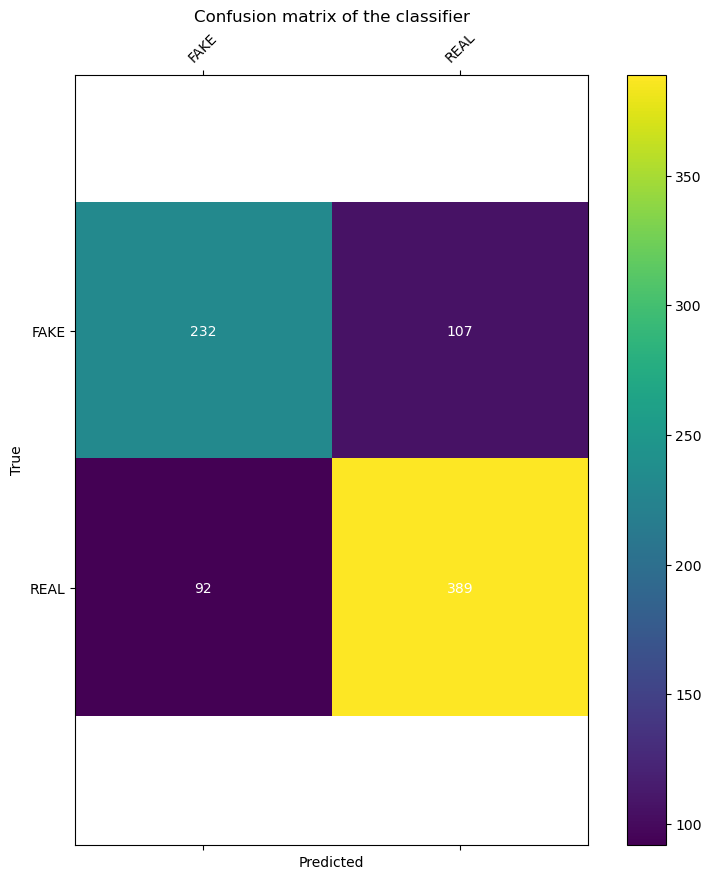

Fold start on items 820 - 1640
Training Classifier...


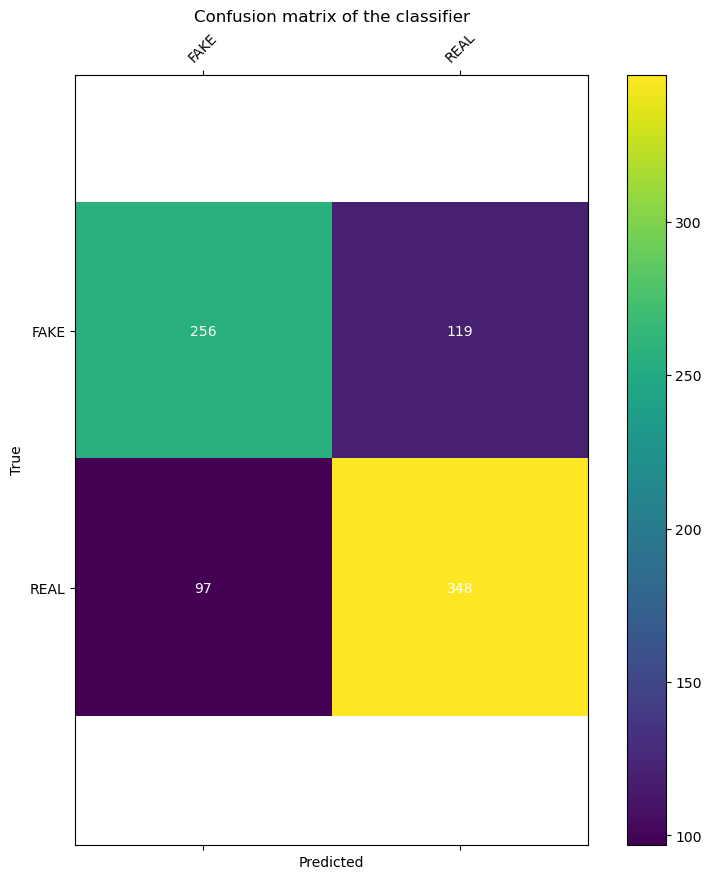

Fold start on items 1640 - 2460
Training Classifier...


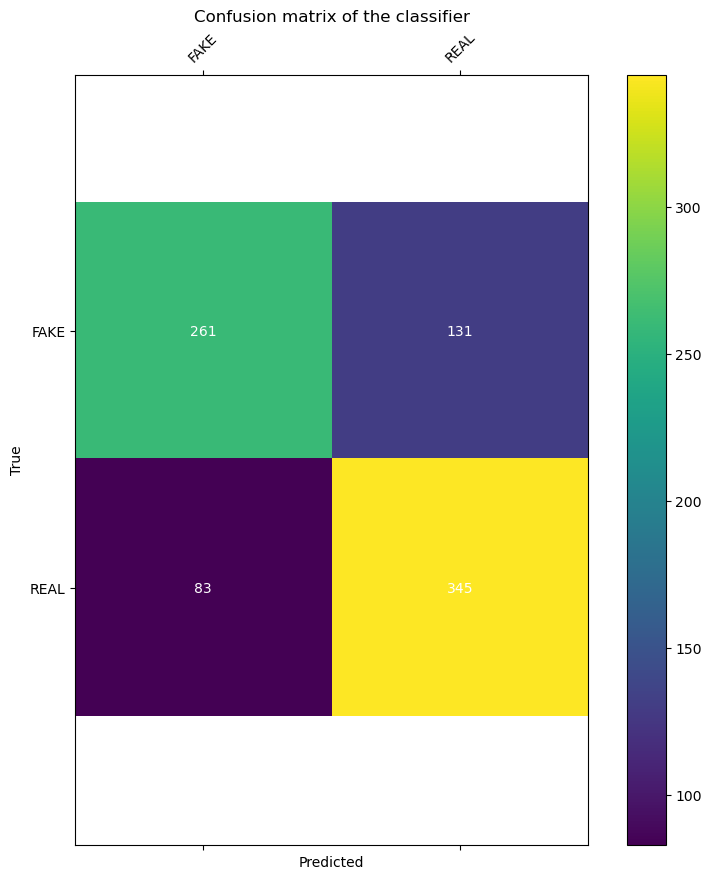

Fold start on items 2460 - 3280
Training Classifier...


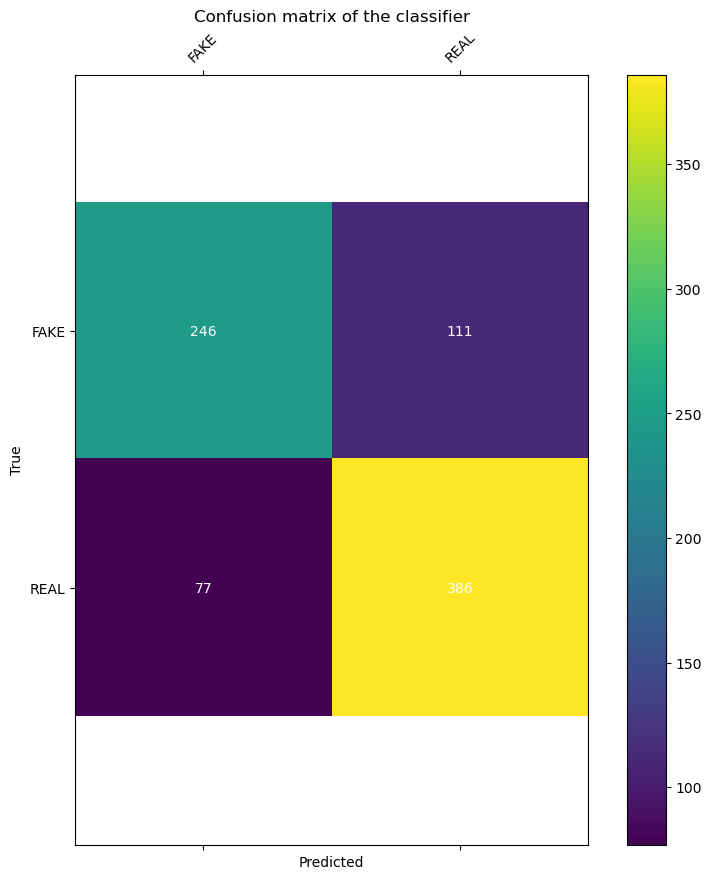

Fold start on items 3280 - 4100
Training Classifier...


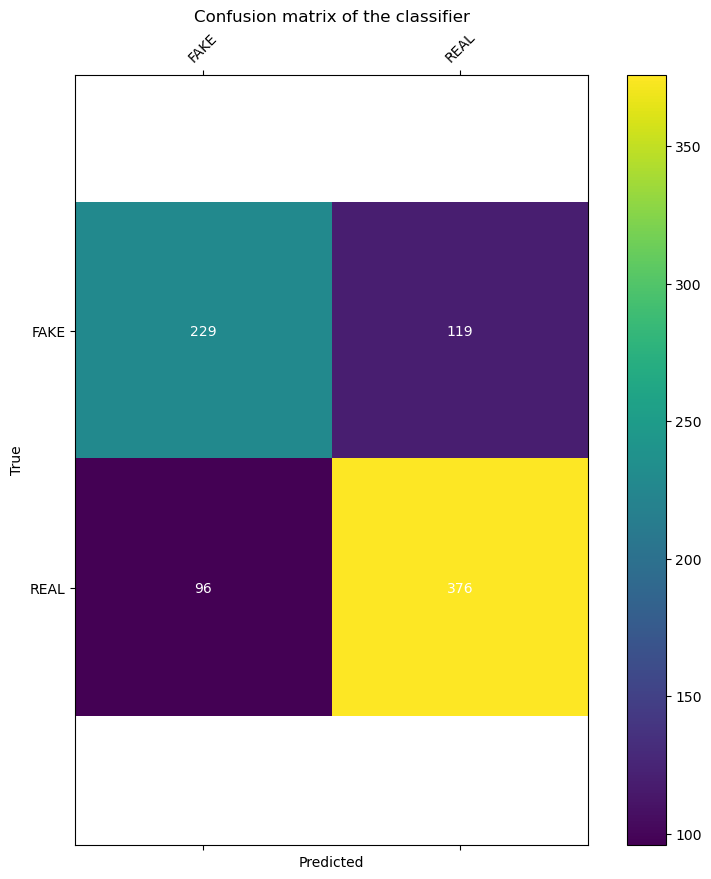

Fold start on items 4100 - 4920
Training Classifier...


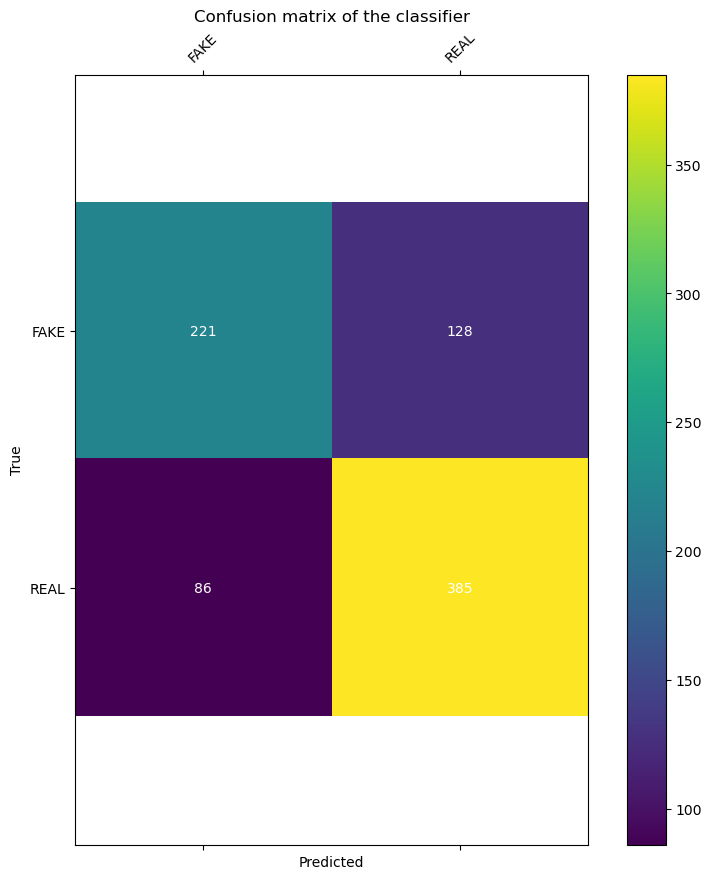

Fold start on items 4920 - 5740
Training Classifier...


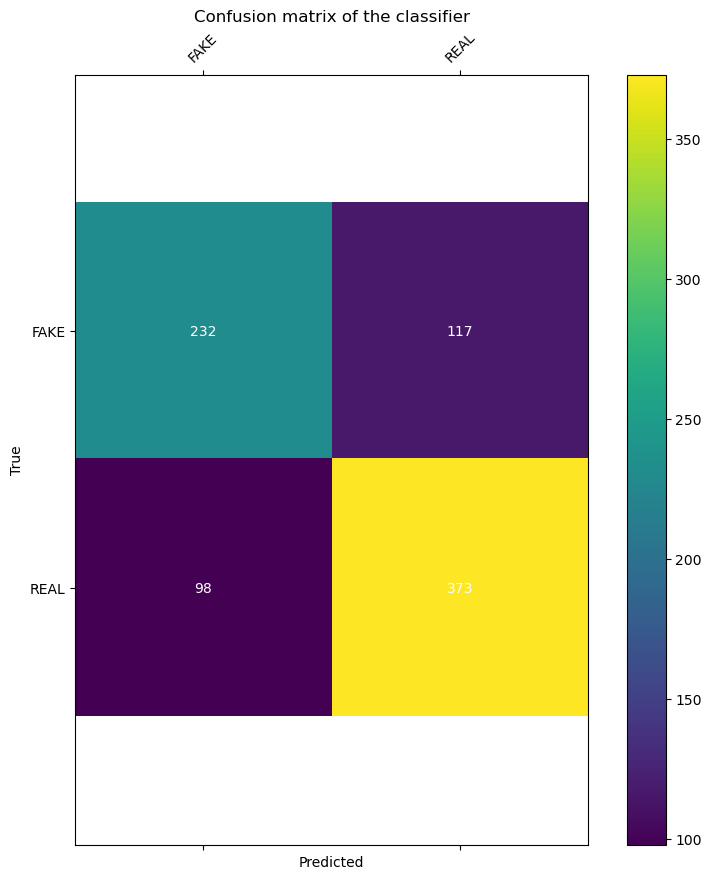

Fold start on items 5740 - 6560
Training Classifier...


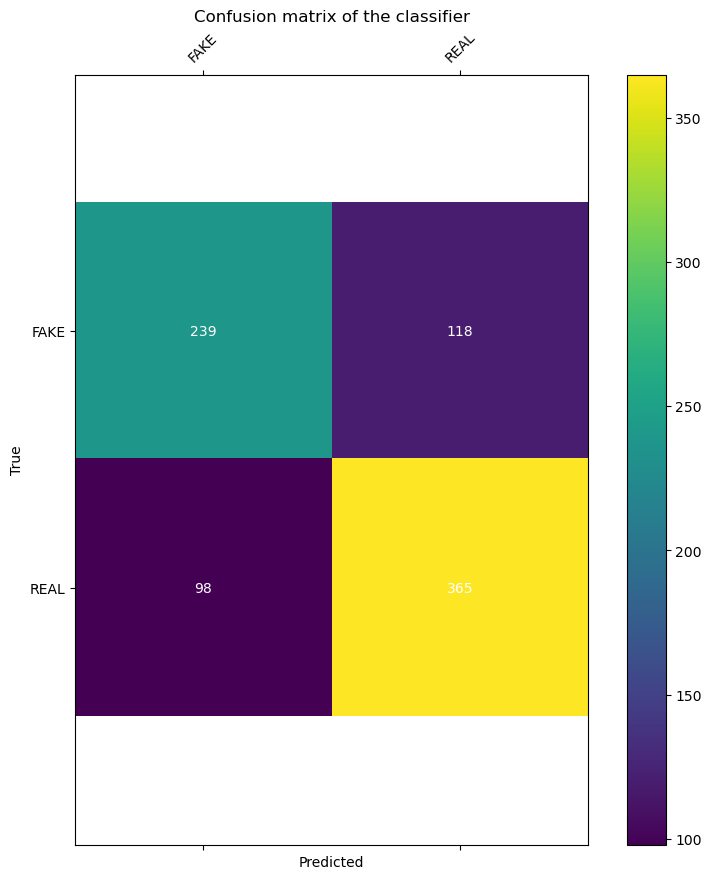

Fold start on items 6560 - 7380
Training Classifier...


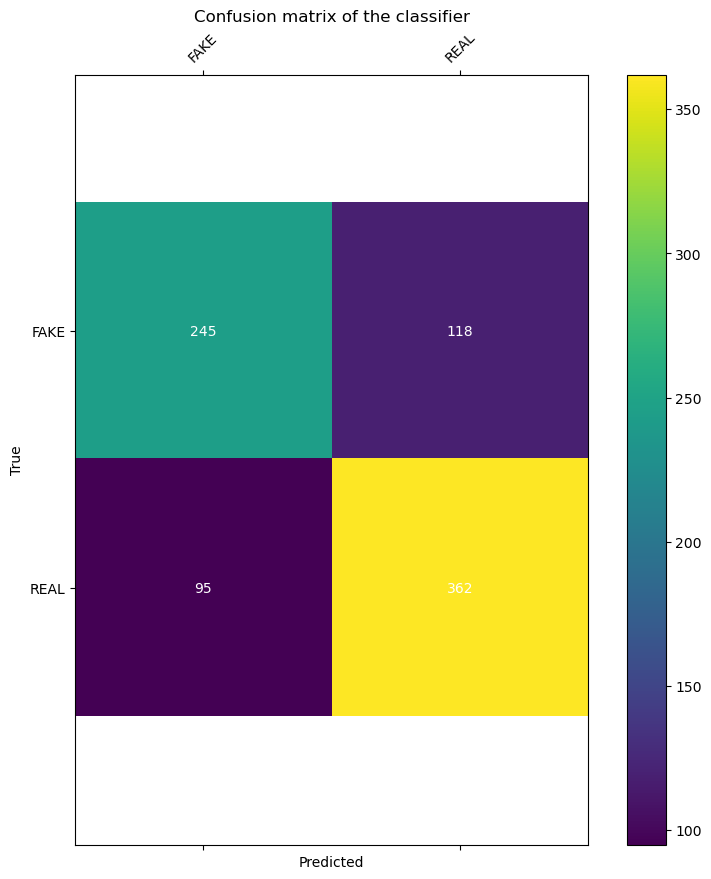

Fold start on items 7380 - 8200
Training Classifier...


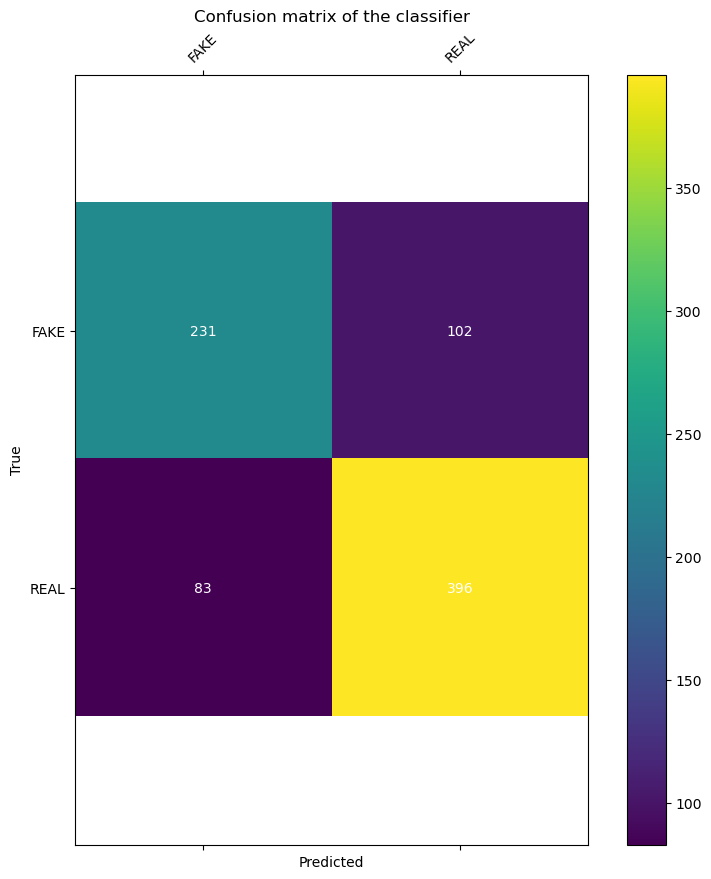

In [28]:
cross_validate_heatmap(train_data, 10)  # will work and output confusion matrix heat map for every fold

### Final test

functions_complete set to True in the FINAL notebook

In [29]:
# Finally, check the accuracy of your classifier by training on all the traning data
# and testing on the test set
# Will only work once all functions are complete
functions_complete = False  # set to True once you're happy with your methods for cross val
if functions_complete:
    print(test_data[0])   # have a look at the first test data instance
    classifier = train_classifier(train_data)  # train the classifier
    test_true = [t[1] for t in test_data]   # get the ground-truth labels from the data
    test_pred = predict_labels([x[0] for x in test_data], classifier)  # classify the test data to get predicted labels
    final_scores = precision_recall_fscore_support(test_true, test_pred, average='weighted') # evaluate
    print("Done training!")
    print("Precision: %f\nRecall: %f\nF Score:%f" % final_scores[:3])